## Predicción de duración de viajes y detección de emergencias en tweets
### Borja Lacalle & Manuel Arias

In [35]:
# Importamos librerías #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

random_state = 100


Parte 1: Predicción de duración de viajes

In [36]:
df = pd.read_csv("uber_time_labels.csv")
df

,id,duration
0,0,455.0
1,1,413.0
2,2,1501.0
3,3,514.0
4,4,605.0
...,...,...
399995,399995,1957.0
399996,399996,167.0
399997,399997,1200.0
399998,399998,1654.0


In [37]:
dfex = pd.read_csv("uber_time_examples.csv")
dfex

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,0,01-07 17:04:08,2,1.20,263,141,12.513054,297.430685,56.317405,405.20,0.408689,126.689773
1,1,03-02 17:41:40,1,0.88,246,68,6.256527,278.205127,27.160167,314.88,-0.256911,126.693467
2,2,02-17 12:15:00,3,7.61,24,13,18.769581,27.141964,5.192385,44.61,56.880789,126.615789
3,3,03-30 13:59:42,1,1.50,239,163,6.256527,270.288721,65.104518,403.50,1.218689,126.686311
4,4,02-14 18:26:55,1,1.20,142,229,6.256527,160.589952,91.465857,372.20,0.408689,126.689773
...,...,...,...,...,...,...,...,...,...,...,...,...
399995,399995,01-31 22:02:08,1,10.00,234,244,6.256527,264.634146,97.457070,488.00,98.968689,126.588204
399996,399996,01-17 15:38:24,1,0.40,162,229,6.256527,183.208255,91.465857,391.40,-0.871311,126.699007
399997,399997,03-13 07:06:05,1,6.18,262,244,6.256527,296.299770,97.457070,512.18,37.161089,126.632294
399998,399998,01-25 17:45:06,2,8.09,138,233,12.513054,156.066291,93.063513,379.09,64.416789,126.610249


In [38]:
data = pd.merge(df, dfex, on='id', how='inner')
data = data.set_index('id')
data.head()

,duration,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
id,,,,,,,,,,,,
0,455.0,01-07 17:04:08,2,1.20,263,141,12.513054,297.430685,56.317405,405.20,0.408689,126.689773
1,413.0,03-02 17:41:40,1,0.88,246,68,6.256527,278.205127,27.160167,314.88,-0.256911,126.693467
2,1501.0,02-17 12:15:00,3,7.61,24,13,18.769581,27.141964,5.192385,44.61,56.880789,126.615789
3,514.0,03-30 13:59:42,1,1.50,239,163,6.256527,270.288721,65.104518,403.50,1.218689,126.686311
4,605.0,02-14 18:26:55,1,1.20,142,229,6.256527,160.589952,91.465857,372.20,0.408689,126.689773


In [39]:
# Tomar una muestra aleatoria de 20,000 registros
data = data.sample(n=20000, replace=False, random_state=42)

# Imprimir el DataFrame resultante
data

,duration,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
id,,,,,,,,,,,,
23218,282.0,03-04 19:03:01,5,0.98,263,141,31.282635,297.430685,56.317405,404.98,-0.070911,126.692312
20731,595.0,03-26 15:50:21,1,1.75,158,164,6.256527,178.684594,65.503932,323.75,2.031189,126.683425
39555,2361.0,01-11 14:57:09,1,9.70,141,220,6.256527,159.459036,87.871129,370.70,93.058689,126.591666
147506,459.0,02-11 12:05:41,4,1.65,114,13,25.026108,128.924327,5.192385,128.65,1.691189,126.684579
314215,291.0,03-07 12:35:52,6,0.82,140,236,37.539162,158.328121,94.261756,376.82,-0.358911,126.694159
...,...,...,...,...,...,...,...,...,...,...,...,...
102238,414.0,03-17 03:44:48,1,2.00,211,234,6.256527,238.623097,93.462928,447.00,2.968689,126.680540
49048,831.0,03-04 05:06:04,1,4.33,87,48,6.256527,98.389618,19.171883,139.33,17.717589,126.653647
90371,441.0,02-22 23:30:29,1,1.06,68,170,6.256527,76.902230,67.900418,239.06,0.092289,126.691389


In [40]:

data.dtypes

duration      float64
feature_0      object
feature_1       int64
feature_2     float64
feature_3       int64
feature_4       int64
feature_5     float64
feature_6     float64
feature_7     float64
feature_8     float64
feature_9     float64
feature_10    float64
dtype: object

In [41]:
# Contar el número total de valores en cada columna
total_values = data.shape[0]

# Calcular el número de valores missing en cada columna
num_missing = data.isnull().sum()

# Calcular el porcentaje de valores missing en cada columna
percent_missing = num_missing / total_values * 100
percent_missing

duration      0.0
feature_0     0.0
feature_1     0.0
feature_2     0.0
feature_3     0.0
feature_4     0.0
feature_5     0.0
feature_6     0.0
feature_7     0.0
feature_8     0.0
feature_9     0.0
feature_10    0.0
dtype: float64

Vemos que no hay ningún valor missing por lo tanto seguimos con nuestro análisis sin necesidad de rellenarlos con la media, la moda o valores muy distintos

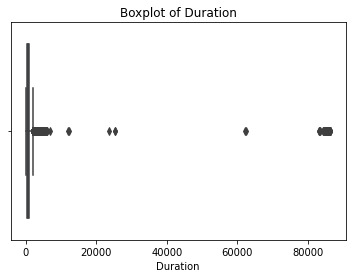

In [42]:
sns.boxplot(data=data, x='duration')
plt.xlabel('Duration')
plt.title('Boxplot of Duration')
plt.show()


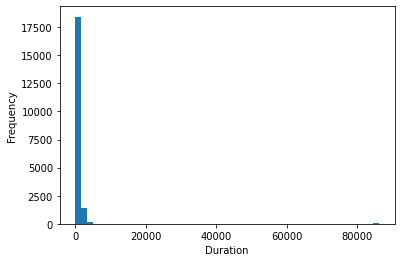

In [43]:

plt.hist(data['duration'], bins=50)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.show()

Con estos dos gráficos podemos observar que la variable objetivo 'duration' no sigue una distribución normal (es estrecha, asimétrica y cercana a 0) y por lo tanto tendremos que hacer una transformación 

In [44]:
# Obtener la variable "duration" del DataFrame
duration = data['duration'].values.reshape(-1, 1)

# Aplicar Power Transformation
pt = PowerTransformer(method='yeo-johnson')
duration_transformed = pt.fit_transform(duration)

# Reemplazar la columna "duration" con la versión transformada
data['duration_transformed'] = duration_transformed
data.head(30)

,duration,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,duration_transformed
id,,,,,,,,,,,,,
23218,282.0,03-04 19:03:01,5,0.98,263,141,31.282635,297.430685,56.317405,404.98,-0.070911,126.692312,-0.916430
20731,595.0,03-26 15:50:21,1,1.75,158,164,6.256527,178.684594,65.503932,323.75,2.031189,126.683425,-0.056463
39555,2361.0,01-11 14:57:09,1,9.70,141,220,6.256527,159.459036,87.871129,370.70,93.058689,126.591666,1.671106
147506,459.0,02-11 12:05:41,4,1.65,114,13,25.026108,128.924327,5.192385,128.65,1.691189,126.684579,-0.361207
314215,291.0,03-07 12:35:52,6,0.82,140,236,37.539162,158.328121,94.261756,376.82,-0.358911,126.694159,-0.881278
190913,885.0,03-26 09:07:51,1,2.00,263,162,6.256527,297.430685,64.705104,427.00,2.968689,126.680540,0.422089
296715,598.0,03-01 09:18:32,1,0.97,142,230,6.256527,160.589952,91.865271,372.97,-0.090411,126.692428,-0.050495
141482,724.0,02-17 22:27:34,6,1.58,234,79,37.539162,264.634146,31.553723,314.58,1.465089,126.685387,0.178181
49119,975.0,02-07 15:52:53,2,2.50,263,151,12.513054,297.430685,60.311547,416.50,5.218689,126.674769,0.541124


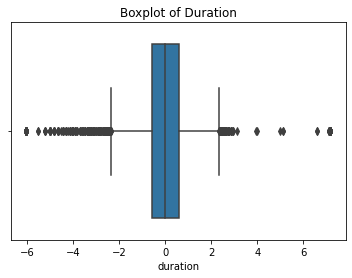

In [45]:
sns.boxplot(data=data, x='duration_transformed')
plt.xlabel('duration')
plt.title('Boxplot of Duration')
plt.show()

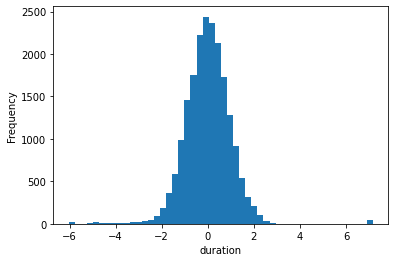

In [46]:
plt.hist(data['duration_transformed'], bins=50)
plt.xlabel('duration')
plt.ylabel('Frequency')
plt.show()

Hemos aplicado un PowerTransformer a la variable objetivo 'duration' y como podemos ver en el boxplot e histograma ahora la variable sigue una distribucion normal y es simétrica, condiciones necesarias para la aplicación posterior de los modelos predictivos

In [47]:
data['new_feature'] = data['feature_7'] * data['feature_3']
data['new_feature1'] = data['feature_2'] * data['feature_9']
data['new_feature2'] = data['feature_6'] * data['feature_5']
data['new_feature3'] = data['feature_4'] * data['feature_9']
data.head()

,duration,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,duration_transformed,new_feature,new_feature1,new_feature2,new_feature3
id,,,,,,,,,,,,,,,,,
23218,282.0,03-04 19:03:01,5,0.98,263,141,31.282635,297.430685,56.317405,404.98,-0.070911,126.692312,-0.916430,14811.477545,-0.069492,9304.415662,-9.998402
20731,595.0,03-26 15:50:21,1,1.75,158,164,6.256527,178.684594,65.503932,323.75,2.031189,126.683425,-0.056463,10349.621286,3.554581,1117.945000,333.115053
39555,2361.0,01-11 14:57:09,1,9.70,141,220,6.256527,159.459036,87.871129,370.70,93.058689,126.591666,1.671106,12389.829125,902.669287,997.659778,20472.911657
147506,459.0,02-11 12:05:41,4,1.65,114,13,25.026108,128.924327,5.192385,128.65,1.691189,126.684579,-0.361207,591.931875,2.790462,3226.474176,21.985462
314215,291.0,03-07 12:35:52,6,0.82,140,236,37.539162,158.328121,94.261756,376.82,-0.358911,126.694159,-0.881278,13196.645851,-0.294307,5943.505062,-84.702914


In [48]:
data.dtypes

duration                float64
feature_0                object
feature_1                 int64
feature_2               float64
feature_3                 int64
feature_4                 int64
feature_5               float64
feature_6               float64
feature_7               float64
feature_8               float64
feature_9               float64
feature_10              float64
duration_transformed    float64
new_feature             float64
new_feature1            float64
new_feature2            float64
new_feature3            float64
dtype: object

In [49]:
# Separar la columna 'fecha' en día, mes y hora
data['dia'] = data['feature_0'].str[:2]
data['mes'] = data['feature_0'].str[3:5]
data['hora'] = data['feature_0'].str[6:]

# Convertir las columnas 'dia', 'mes' y 'hora' en tipo numérico
data['dia'] = pd.to_numeric(data['dia'])
data['mes'] = pd.to_numeric(data['mes'])

# Imprimir el DataFrame resultante
data

,duration,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,duration_transformed,new_feature,new_feature1,new_feature2,new_feature3,dia,mes,hora
id,,,,,,,,,,,,,,,,,,,,
23218,282.0,03-04 19:03:01,5,0.98,263,141,31.282635,297.430685,56.317405,404.98,-0.070911,126.692312,-0.916430,14811.477545,-0.069492,9304.415662,-9.998402,3,4,19:03:01
20731,595.0,03-26 15:50:21,1,1.75,158,164,6.256527,178.684594,65.503932,323.75,2.031189,126.683425,-0.056463,10349.621286,3.554581,1117.945000,333.115053,3,26,15:50:21
39555,2361.0,01-11 14:57:09,1,9.70,141,220,6.256527,159.459036,87.871129,370.70,93.058689,126.591666,1.671106,12389.829125,902.669287,997.659778,20472.911657,1,11,14:57:09
147506,459.0,02-11 12:05:41,4,1.65,114,13,25.026108,128.924327,5.192385,128.65,1.691189,126.684579,-0.361207,591.931875,2.790462,3226.474176,21.985462,2,11,12:05:41
314215,291.0,03-07 12:35:52,6,0.82,140,236,37.539162,158.328121,94.261756,376.82,-0.358911,126.694159,-0.881278,13196.645851,-0.294307,5943.505062,-84.702914,3,7,12:35:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102238,414.0,03-17 03:44:48,1,2.00,211,234,6.256527,238.623097,93.462928,447.00,2.968689,126.680540,-0.480633,19720.677731,5.937379,1492.951867,694.673308,3,17,03:44:48
49048,831.0,03-04 05:06:04,1,4.33,87,48,6.256527,98.389618,19.171883,139.33,17.717589,126.653647,0.345197,1667.953785,76.717162,615.577310,850.444289,3,4,05:06:04
90371,441.0,02-22 23:30:29,1,1.06,68,170,6.256527,76.902230,67.900418,239.06,0.092289,126.691389,-0.407626,4617.228391,0.097827,481.140886,15.689189,2,22,23:30:29


In [50]:
data['hora'] = pd.to_datetime(data['hora'], format='%H:%M:%S').dt.time

In [51]:
data['hora_punta'] = data['hora'].apply(lambda x: 1 if ((x >= pd.to_datetime('7:30').time() and x <= pd.to_datetime('9:30').time()) or (x >= pd.to_datetime('17:00').time() and x <= pd.to_datetime('20:00').time())) else 0)

In [52]:
data.head(10)

,duration,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_10,duration_transformed,new_feature,new_feature1,new_feature2,new_feature3,dia,mes,hora,hora_punta
id,,,,,,,,,,,,,,,,,,,,,
23218,282.0,03-04 19:03:01,5,0.98,263,141,31.282635,297.430685,56.317405,404.98,...,126.692312,-0.916430,14811.477545,-0.069492,9304.415662,-9.998402,3,4,19:03:01,1
20731,595.0,03-26 15:50:21,1,1.75,158,164,6.256527,178.684594,65.503932,323.75,...,126.683425,-0.056463,10349.621286,3.554581,1117.945000,333.115053,3,26,15:50:21,0
39555,2361.0,01-11 14:57:09,1,9.70,141,220,6.256527,159.459036,87.871129,370.70,...,126.591666,1.671106,12389.829125,902.669287,997.659778,20472.911657,1,11,14:57:09,0
147506,459.0,02-11 12:05:41,4,1.65,114,13,25.026108,128.924327,5.192385,128.65,...,126.684579,-0.361207,591.931875,2.790462,3226.474176,21.985462,2,11,12:05:41,0
314215,291.0,03-07 12:35:52,6,0.82,140,236,37.539162,158.328121,94.261756,376.82,...,126.694159,-0.881278,13196.645851,-0.294307,5943.505062,-84.702914,3,7,12:35:52,0
190913,885.0,03-26 09:07:51,1,2.00,263,162,6.256527,297.430685,64.705104,427.00,...,126.680540,0.422089,17017.442285,5.937379,1860.883132,480.927674,3,26,09:07:51,1
296715,598.0,03-01 09:18:32,1,0.97,142,230,6.256527,160.589952,91.865271,372.97,...,126.692428,-0.050495,13044.868447,-0.087698,1004.735379,-20.794450,3,1,09:18:32,1
141482,724.0,02-17 22:27:34,6,1.58,234,79,37.539162,264.634146,31.553723,314.58,...,126.685387,0.178181,7383.571283,2.314841,9934.144175,115.742059,2,17,22:27:34,0
49119,975.0,02-07 15:52:53,2,2.50,263,151,12.513054,297.430685,60.311547,416.50,...,126.674769,0.541124,15861.936945,13.046723,3721.766265,788.022092,2,7,15:52:53,0


In [53]:
data = data.drop(['hora', 'feature_0', 'duration'], axis=1)
data

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,duration_transformed,new_feature,new_feature1,new_feature2,new_feature3,dia,mes,hora_punta
id,,,,,,,,,,,,,,,,,,
23218,5,0.98,263,141,31.282635,297.430685,56.317405,404.98,-0.070911,126.692312,-0.916430,14811.477545,-0.069492,9304.415662,-9.998402,3,4,1
20731,1,1.75,158,164,6.256527,178.684594,65.503932,323.75,2.031189,126.683425,-0.056463,10349.621286,3.554581,1117.945000,333.115053,3,26,0
39555,1,9.70,141,220,6.256527,159.459036,87.871129,370.70,93.058689,126.591666,1.671106,12389.829125,902.669287,997.659778,20472.911657,1,11,0
147506,4,1.65,114,13,25.026108,128.924327,5.192385,128.65,1.691189,126.684579,-0.361207,591.931875,2.790462,3226.474176,21.985462,2,11,0
314215,6,0.82,140,236,37.539162,158.328121,94.261756,376.82,-0.358911,126.694159,-0.881278,13196.645851,-0.294307,5943.505062,-84.702914,3,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102238,1,2.00,211,234,6.256527,238.623097,93.462928,447.00,2.968689,126.680540,-0.480633,19720.677731,5.937379,1492.951867,694.673308,3,17,0
49048,1,4.33,87,48,6.256527,98.389618,19.171883,139.33,17.717589,126.653647,0.345197,1667.953785,76.717162,615.577310,850.444289,3,4,0
90371,1,1.06,68,170,6.256527,76.902230,67.900418,239.06,0.092289,126.691389,-0.407626,4617.228391,0.097827,481.140886,15.689189,2,22,0


In [54]:
data['hora_punta'].value_counts()

0    14496
1     5504
Name: hora_punta, dtype: int64

In [55]:
from sklearn.model_selection import train_test_split

# Separar la variable objetivo
y = data['duration_transformed']

# Separar las variables predictoras
X = data.drop('duration_transformed', axis=1)



In [56]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# Entrena un modelo de Bosques Aleatorios
model = RandomForestRegressor()
model.fit(X, y)

# Utiliza SelectFromModel para seleccionar las características más importantes
selector = SelectFromModel(model, threshold='mean')
selector.fit(X, y)

# Filtra las características seleccionadas en el DataFrame de datos
X_selected = X[X.columns[selector.get_support()]]

X_selected



,feature_2,feature_9,feature_10,new_feature1
id,,,,
23218,0.98,-0.070911,126.692312,-0.069492
20731,1.75,2.031189,126.683425,3.554581
39555,9.70,93.058689,126.591666,902.669287
147506,1.65,1.691189,126.684579,2.790462
314215,0.82,-0.358911,126.694159,-0.294307
...,...,...,...,...
102238,2.00,2.968689,126.680540,5.937379
49048,4.33,17.717589,126.653647,76.717162
90371,1.06,0.092289,126.691389,0.097827


In [57]:
# data_selected = pd.merge(y, X_selected, on='id', how='inner')
# data_selected

In [58]:
# Separar en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)


In [59]:
# Partimos en entrenamiento y test
# data_train, data_test = train_test_split(data_selected, test_size = 0.3, random_state = random_state)
# X_train = data_train.drop(columns='duration_transformed')
# y_train = data_train['duration_transformed']
# X_test = data_test.drop(columns='duration_transformed')
# y_test = data_test['duration_transformed']

### Entrenaremos el modelo primero con un LINEAL REGRESSION

In [60]:
lr = LinearRegression(normalize=False)

In [61]:
lr.fit(X_train,y_train)

c:\Users\blaca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


LinearRegression(normalize=False)

In [62]:
print(lr.score(X_train, y_train))
lr.score(X_test,y_test)

0.5131947249516358


0.4837412110741488

In [63]:
# predictions = lr.predict(X_test)
# results_df = ( data_test
#     .loc[:,['duration_transformed']]
#     .assign(DurationPredicted=predictions)
#     .assign(SquaredError=lambda x:(x.duration_transformed - x.DurationPredicted)**2)
# )
# results_df.head()

In [64]:
# np.sqrt(results_df['SquaredError'].mean())


In [65]:
# from sklearn.metrics import mean_squared_error
# rmse_2 = mean_squared_error(results_df['duration_transformed'], results_df['DurationPredicted'], squared=False)
# rmse_2


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge

# Paso 1: Entrenamiento del modelo sencillo (Regresión Lineal)
# Crea una instancia del modelo y ajústalo a los datos de entrenamiento
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
linear_predictions = linear_model.predict(X_test)

# Calcula el MAPE para el modelo sencillo
linear_mape = mean_absolute_percentage_error(y_test, linear_predictions)

# Paso 2: Entrenamiento del modelo más complejo (Random Forest)
# Crea una instancia del modelo y ajústalo a los datos de entrenamiento
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
# Predicciones en el conjunto de prueba
rf_predictions = rf_model.predict(X_test)

# Calcula el MAPE para el modelo más complejo
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)

# Paso 3: Entrenamiento del modelo más complejo (maquina de soporte vector)
# Crea una instancia del modelo y ajústalo a los datos de entrenamiento
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = svr_model.predict(X_test)

# Calcular el MAPE
svr_mape = mean_absolute_percentage_error(y_test, y_pred)

#paso 4: Entrenamiento del modelo
model = BayesianRidge()
model.fit(X_train, y_train)

#Realizar predicciones en el conjunto de prueba
y_preds = model.predict(X_test)

# Calcular el MAPE
mae = mean_absolute_percentage_error(y_test, y_preds)


# Paso 4: Comparación de los resultados
print("MAPE para Regresión Lineal:", linear_mape)
print("MAPE para Random Forest:", rf_mape)
print("MAPE para Maquina de Soporte Vector:", svr_mape)
print("MAPE para Modelo Bayesiano:", mae)